In [2]:
import os
os.environ['JAX_CHECK_TRACER_LEAKS'] = '1'

In [3]:
import tensorflow as tf
import numpy as np

# Initialize dummy data and labels
X = np.random.rand(10, 4).astype('float32')  # 10 samples, 4 features
y = np.random.randint(0, 2, size=(10, 1)).astype('float32')  # 10 labels, binary classification

# Initialize weights and biases to 0.1
W = tf.Variable(np.full((4, 1), 0.01), dtype=tf.float32)
b = tf.Variable(np.full((1,), 0.01), dtype=tf.float32)

# Create a function to compute forward pass and loss
def forward_and_loss(X, y, W, b):
    z = tf.matmul(X, W) + b
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=z))
    return loss

# Create a function to compute gradients
def compute_gradients(X, y, W, b):
    with tf.GradientTape() as tape:
        tape.watch([W, b])
        loss = forward_and_loss(X, y, W, b)
    gradients = tape.gradient(loss, [W, b])
    return loss, gradients

# Compute gradients
loss, gradients = compute_gradients(X, y, W, b)
print('loss', loss)
print("Gradient with respect to weights:\n", gradients[0].numpy())
print("Gradient with respect to bias:\n", gradients[1].numpy())

2023-10-26 23:36:52.712121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 23:36:52.712219: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 23:36:52.712255: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import sys
sys.path.append('/home/jaxmao/jaxmao_branches/JaxMao/')

import jax
from jaxmao.modules import Module
from jaxmao.layers import Dense
from jaxmao.initializers import ConstantInitalzer
from jaxmao.losses import BinaryCrossEntropy

class DenseSigmoid(Module):
    def __init__(self):
        super().__init__()
        self.dense = Dense(4, 1, 
              weights_initializer=ConstantInitalzer(value=0.01),
              bias_initializer=ConstantInitalzer(value=0.01)
              )
    def __call__(self, x):
        return jax.nn.sigmoid(self.dense(x))

dense = DenseSigmoid()
dense.init_params(jax.random.key(0))
loss_fn = BinaryCrossEntropy()

@jax.jit
def _loss_fn(params, x, y):
    y_pred = dense.apply(params, x)
    loss = loss_fn(y_pred, y)
    return loss

loss_and_grad = jax.value_and_grad(_loss_fn, argnums=0)

jm_losses, jm_gradients = loss_and_grad(dense.params, X, y)
print('loss', jm_losses)
print('grad weights\n', jm_gradients['dense']['weights'])
print('grad biases\n', jm_gradients['dense']['biases'])

loss 0.6895835
grad weights
 [[0.]
 [0.]
 [0.]
 [0.]]
grad biases
 [0.]


#### different in gradients
very small

In [ ]:
jm_losses - loss

<tf.Tensor: shape=(), dtype=float32, numpy=5.9604645e-08>

In [ ]:
jm_gradients['dense']['weights'] - gradients[0].numpy()

Array([[0.05428455],
       [0.01591844],
       [0.16974564],
       [0.0120199 ]], dtype=float32)

In [ ]:
jm_gradients['dense']['biases'] - gradients[1].numpy()

Array([0.09245726], dtype=float32)

## Two layers dense

In [ ]:
import numpy as np

# Initialize dummy data and labels
X = np.random.rand(10, 4).astype(np.float32)  # 10 samples, 4 features
y = np.random.randint(0, 2, size=(10, 1)).astype(np.float32)  # 10 labels, binary classification

In [2]:
import tensorflow as tf

# Create a two-layer model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='sigmoid', kernel_initializer='ones', bias_initializer='ones'),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='ones', bias_initializer='ones')
])

# Initialize model weights
model(X)  # Forward pass to initialize weights

# Compute gradients using TensorFlow
with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    predictions = model(X)
    loss = tf.keras.losses.BinaryCrossentropy()(y, predictions)
    
tf_gradients = tape.gradient(loss, model.trainable_variables)

print('loss', loss)
# Display gradients
for i, grad in enumerate(tf_gradients):
    print(f"Layer {i + 1} gradients:\n{grad.numpy()}")

2023-10-27 01:44:53.974138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 01:44:53.974268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 01:44:53.974544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 01:44:55.471149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


loss tf.Tensor(1.7022848, shape=(), dtype=float32)
Layer 1 gradients:
[[0.0087981  0.0087981  0.0087981  0.0087981  0.0087981 ]
 [0.00357569 0.00357569 0.00357569 0.00357569 0.00357569]
 [0.01256735 0.01256735 0.01256735 0.01256735 0.01256735]
 [0.00408317 0.00408317 0.00408317 0.00408317 0.00408317]]
Layer 2 gradients:
[0.01849792 0.01849792 0.01849792 0.01849792 0.01849792]
Layer 3 gradients:
[[0.2767474]
 [0.2767474]
 [0.2767474]
 [0.2767474]
 [0.2767474]]
Layer 4 gradients:
[0.29675758]


2023-10-27 01:44:57.250108: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [1]:
import os
# os.environ['JAX_TRACEBACK_FILTERING'] = 'off'
os.environ['JAX_CHECK_TRACER_LEAKS'] = 'on'

import numpy as np

# Initialize dummy data and labels
X = np.random.rand(10, 4).astype(np.float32)  # 10 samples, 4 features
y = np.random.randint(0, 2, size=(10, 1)).astype(np.float32)  # 10 labels, binary classification

import sys
sys.path.append('/home/jaxmao/jaxmao_branches/JaxMao/')

import jax
from jaxmao.modules import Module
from jaxmao.layers import Dense
from jaxmao.initializers import ones_initializer
from jaxmao.losses import BinaryCrossEntropy

class TwoLayers(Module):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(4, 5, 
                weights_initializer=ones_initializer,
                bias_initializer=ones_initializer
              )
        self.dense2 = Dense(5, 1,
                weights_initializer=ones_initializer,
                bias_initializer=ones_initializer
            )
    def __call__(self, x):
        return jax.nn.sigmoid(self.dense2(jax.nn.sigmoid(self.dense1(x))))

dense = TwoLayers()
dense.init_params(jax.random.key(0))
loss_fn = BinaryCrossEntropy()

# @jax.jit
def _loss_fn(params, x, y):
    return loss_fn(dense.apply(params, x), y)

loss_and_grad = jax.value_and_grad(_loss_fn, argnums=0)

jax.tree_util.tree_map(lambda x: x+5, dense.params)
losses2, grads = loss_and_grad(dense.params, X, y)
print('loss', losses2)

losses2, grads

I0000 00:00:1698345879.425312  231857 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


loss 1.7022867


(Array(1.7022867, dtype=float32),
 FrozenDict({'dense1': FrozenDict({'biases': Array([0.01849792, 0.01849792, 0.01849792, 0.01849792, 0.01849792],      dtype=float32), 'weights': Array([[0.0087981 , 0.0087981 , 0.0087981 , 0.0087981 , 0.0087981 ],
        [0.00357569, 0.00357569, 0.00357569, 0.00357569, 0.00357569],
        [0.01256735, 0.01256735, 0.01256735, 0.01256735, 0.01256735],
        [0.00408317, 0.00408317, 0.00408317, 0.00408317, 0.00408317]],      dtype=float32)}), 'dense2': FrozenDict({'biases': Array([0.29675755], dtype=float32), 'weights': Array([[0.2767474],
        [0.2767474],
        [0.2767474],
        [0.2767474],
        [0.2767474]], dtype=float32)})}))

In [3]:
grads['dense1']['biases'] - tf_gradients[1]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.8626451e-09, 1.8626451e-09, 1.8626451e-09, 1.8626451e-09,
       1.8626451e-09], dtype=float32)>

In [4]:
grads['dense2']['weights'] - tf_gradients[2]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [ ]:
grads['dense2']['biases'] - tf_gradients[3]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-5.9604645e-08], dtype=float32)>

# approximate $3x$

loss 0.32810944
loss 0.32810944


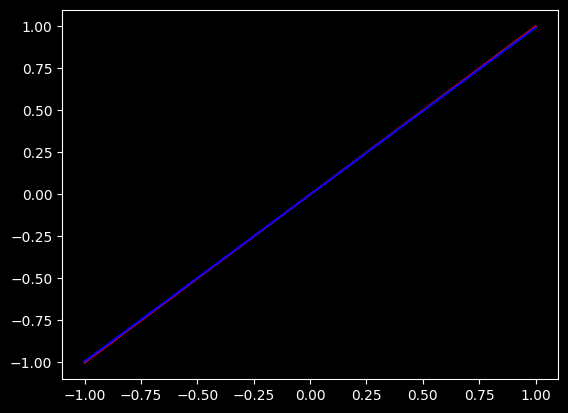

In [ ]:
import matplotlib.pyplot as plt
from jaxmao.losses import MeanSquaredError

x = np.linspace(-5, 5, 500).reshape(-1, 1)
y = (lambda x: 3*x)(x)
x = (x-x.mean()) / x.max()
y = (y-y.mean()) / y.max()

dense = Dense(1, 1, 
        weights_initializer=ConstantInitalzer(value=0.01),
        bias_initializer=ConstantInitalzer(value=0.01)
        )

dense.init_params(jax.random.key(0))
loss_fn = MeanSquaredError()

def _loss_fn(params, x, y):
    y_pred = dense.apply(params, x)
    loss = loss_fn(y_pred, y)
    return loss
loss_and_grad = jax.value_and_grad(_loss_fn, argnums=0)

jm_losses, jm_gradients = loss_and_grad(dense.params, x, y)
print('loss', jm_losses)

loss_fn = MeanSquaredError()

@jax.jit
def _loss_fn(params, x, y):
    y_pred = dense.apply(params, x)
    return loss_fn(y_pred, y)

from jaxmao.optimizers import GradientDescent
optimizer = GradientDescent(params=dense.params, lr=0.01)
optimizer.step = jax.jit(optimizer.step)
loss_and_grad = jax.jit(jax.value_and_grad(_loss_fn, argnums=0))
BATCH_SIZE = 32
for epoch in range(50):
    for num_batch in range(len(x) // BATCH_SIZE):
        loss, grads = loss_and_grad(dense.params, x, y)
        dense.params, optimizer.state = optimizer(dense.params, grads, optimizer.state)
    # print('epoch {}'.format(epoch))
print('loss', jm_losses)
y_pred = dense(x)
plt.plot(x, y, c='r')
plt.plot(x, y_pred, c='b')

# approximit $x^2$

Test Loss: 106.71399688720703
4/4 [==============================] - 0s 3ms/step
R^2 Score: 0.8846196400797698


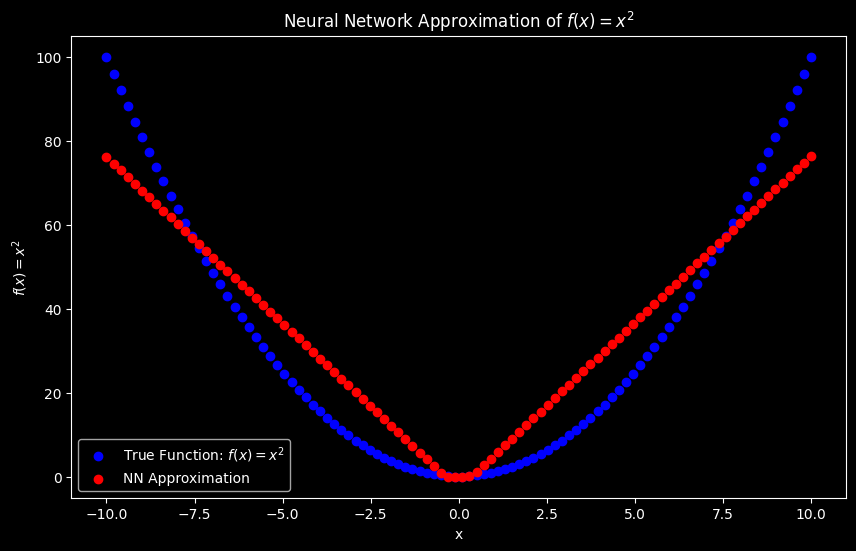

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Generate synthetic data for x and f(x) = x^2
x_train = np.linspace(-10, 10, 1000).reshape(-1, 1)
y_train = np.square(x_train)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),  # Hidden layer 1
    tf.keras.layers.Dense(10, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=50, verbose=0)

# Evaluate the model
x_test = np.linspace(-10, 10, 100).reshape(-1, 1)
y_test = np.square(x_test)
loss = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss}")

# Make predictions
y_pred = model.predict(x_test)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

# Plot the true function and the approximation
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, label='True Function: $f(x) = x^2$', color='blue')
plt.scatter(x_test, y_pred, label='NN Approximation', color='red')
plt.xlabel('x')
plt.ylabel('$f(x) = x^2$')
plt.legend()
plt.title('Neural Network Approximation of $f(x) = x^2$')
plt.show()

In [ ]:
from jaxmao import initializers
class SimpleRegressor(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Dense(1, 10)
        self.fc2 = Dense(10, 10)
        self.fc3 = Dense(10, 1)
                
    def __call__(self, x):
        x = jax.nn.relu(self.fc1(x))
        x = jax.nn.relu(self.fc2(x))
        x = self.fc3(x)
        return x

reg = SimpleRegressor()
reg.init_params(jax.random.key(5))

from jaxmao.optimizers import Adam
from jaxmao.losses import MeanSquaredError

mse = MeanSquaredError()

@jax.jit
def _loss_fn(params, x, y):
    y_pred = reg.apply(params, x)
    loss = mse(y_pred, y)
    return loss

optimizer = Adam(params=reg.params, lr=0.01)
optimizer.step = jax.jit(optimizer.step)
loss_and_grad = jax.jit(jax.value_and_grad(_loss_fn, argnums=0))
# loss_and_grad(reg.params, x, y)

BATCH_SIZE = 32
for epoch in range(30):
    for num_batch in range(len(x_train) // BATCH_SIZE):
        loss, grads = loss_and_grad(reg.params, x_train, y_train)
        reg.params, optimizer.state = optimizer(reg.params, grads, optimizer.state)
        # print(grads)
    # print('epoch {}: {}'.format(epoch, loss))

loss:  3146.621
r2  -2.4021617203890306


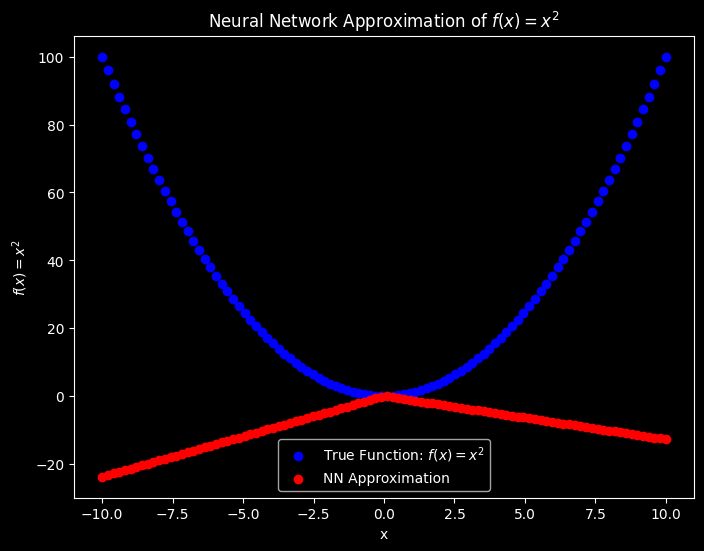

In [ ]:
y_pred = reg.apply(reg.params, x_test)

print('loss: ', MeanSquaredError()(y_pred, y_test))
print('r2 ', r2_score(y_test, y_pred))

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='True Function: $f(x) = x^2$', color='blue')
plt.scatter(x_test, y_pred, label='NN Approximation', color='red')
plt.xlabel('x')
plt.ylabel('$f(x) = x^2$')
plt.legend()
plt.title('Neural Network Approximation of $f(x) = x^2$')
plt.show()